# INSTAGRAM: DETECCIÓN DE USUARIOS FALSOS

## **Entrenamiento y evaluación de modelos**

<img src="https://miracomohacerlo.com/wp-content/uploads/2019/02/como-ver-a-que-fotos-le-da-like-en-instagram-una-persona-2.jpg" />

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper

## **DATASET**

In [65]:
dataset_original = pd.read_csv('instagram.csv')
dataset = dataset_original

renamed_columns = {'pos':'post','flw':'followers','flg':'following','bl':'biography_lenght','pic':'profile_picture','lin':'external_url','cl':'post_lenght','cz':'post_lenght_null','ni':'none_image','erl':'engagement_rate_likes','erc':'engagement_rate_comments','lt':'post_location','hc':'hashtags_post','pr':'hashtags_promotional','fo':'hashtags_followers','cs':'cosine_similarity','pi':'interval_post','class':'user_class'}
dataset.rename(columns = renamed_columns, inplace = True)

dataset["user_class"] = dataset.user_class.replace(['f','r'], [0, 1])

### **Train, Validation, Test**

In [ ]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

## **MÉTRICAS**

1) Se debe elegir y definir una **métrica de performance** a utilizar para **evaluar los modelos**. Fundamentar la elección de la métrica.

Precision porque ...

2) Se debe aplicar alguna **técnica de feature engineering** para mejorar la data de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.

## FEATURE ENGINEERING

### Binning: 
Utilizamos la técnica de redondeo para las siguientes variables:
- post
- followers
- followings
- biography_lenght
- post_lenght
- engagement_rate_likes
- engagement_rate_comments
- hashtags_post
- hashtags_promotional
- hashtags_followers
- interval_post

### One-hotEnconder:
Generamos nuevas columnas a partir de las siguientes variables:
- Profile_picture
- External_URL

Consideramos que las siguientes variables no necesitan una transformación ya que contienen valores que corresponden a porcentajes entre 0 y 1:
- post_lenght_null
- none_image
- post_location
- cosine_similarity

### **MAPPER**

In [39]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [40]:
mapper = DataFrameMapper([
    (['post'], [StandardScaler()]),
    (['followers'], [StandardScaler()]),
    (['following'], [StandardScaler()]),
    (['biography_lenght'], [StandardScaler()]),
    (['profile_picture'], [OneHotEncoder()]),
    (['external_url'], [OneHotEncoder()]),
    (['post_lenght'], [StandardScaler()]),
    (['engagement_rate_likes'], [StandardScaler()]),
    (['engagement_rate_comments'], [StandardScaler()]),
    (['hashtags_post'], [StandardScaler()]),
    (['hashtags_promotional'], [StandardScaler()]),
    (['hashtags_followers'], [StandardScaler()]),
    (['interval_post'], [StandardScaler()])
])

mapper.fit(train)
mapper.transform(train)

array([[-0.2636046 , -0.04885511, -0.86432502, ..., -0.14486718,
        -0.09769564, -0.52746529],
       [-0.23830001, -0.00962227, -0.5083798 , ..., -0.14486718,
        -0.09769564,  1.78708187],
       [-0.2636046 , -0.03606782, -0.52109213, ..., -0.14486718,
        -0.09769564, -0.52746529],
       ...,
       [-0.26062759, -0.03143589, -0.79228848, ..., -0.14486718,
        -0.09769564,  3.71740447],
       [-0.23234599, -0.04699442, -0.76532294, ..., -0.14486718,
        -0.09769564, -0.52199937],
       [-0.16089772, -0.00962227, -0.53688624, ..., -0.14486718,
         0.00375756, -0.37433534]])

In [41]:
mapper.transformed_names_

['post',
 'followers',
 'following',
 'biography_lenght',
 'profile_picture_x0_0',
 'profile_picture_x0_1',
 'external_url_x0_0',
 'external_url_x0_1',
 'post_lenght',
 'engagement_rate_likes',
 'engagement_rate_comments',
 'hashtags_post',
 'hashtags_promotional',
 'hashtags_followers',
 'interval_post']

3) Por cada modelo, se debe **entrenarlo y evaluar** su comportamiento con la **métrica** elegida. Sacar conclusiones respecto a los motivos por los cuales el modelo funciona bien o mal.

## **MODELOS**

### **Función para evaluar modelos**

In [50]:
from sklearn import metrics

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [49]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.user_class
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['real', 'fake'])
            ax.yaxis.set_ticklabels(['real', 'fake'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

### **REGRESIÓN LOGÍSTICA**

In [42]:
from sklearn.linear_model import LogisticRegression

,Accuracy,Precision,Recall,F1
train,0.793418,0.790967,0.794821,0.792889
validation,0.793035,0.786462,0.795271,0.790842


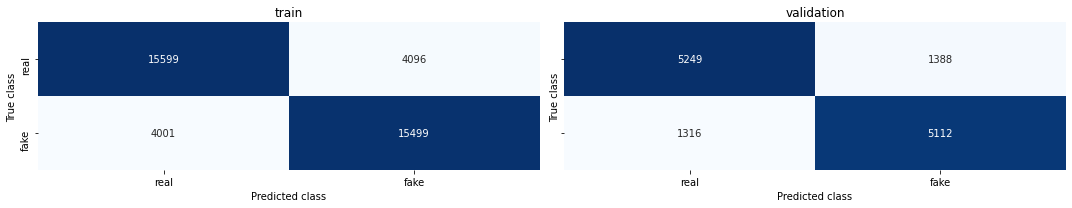

In [51]:
model_lr = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

model_lr.fit(train, train.user_class)

evaluate_model(model_lr)

In [ ]:
ver grafico de coeficientes

### **K NEAREST NEIGHBORS**

In [52]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.851869,0.836627,0.872667,0.854267
validation,0.822197,0.803579,0.845208,0.823868


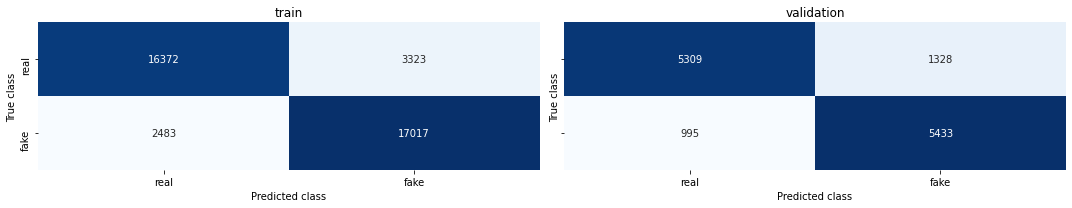

In [53]:
K = 10

model_knn = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

model_knn.fit(train, train.user_class)

evaluate_model(model_knn, title='Knn')

### **ÁRBOLES DE DECISIÓN**

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.999974,1.000000,0.999949,0.999974
validation,0.854573,0.856423,0.846297,0.851330


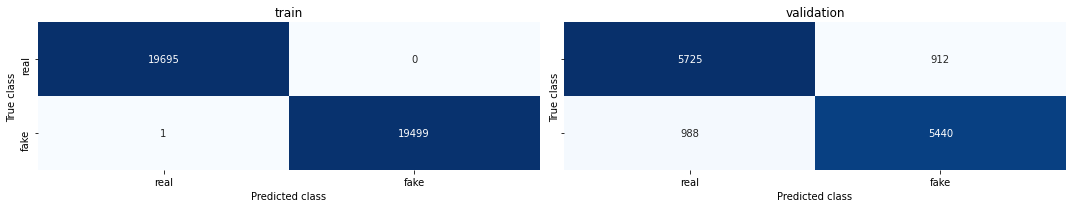

In [63]:
model_tree = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42)),
])

model_tree.fit(train, train.user_class)

evaluate_model(model_tree, title='Decision Tree')

In [ ]:
Está sobreentrenando.

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.90657,0.857033,0.974821,0.912140
validation,0.88695,0.837032,0.956441,0.892761


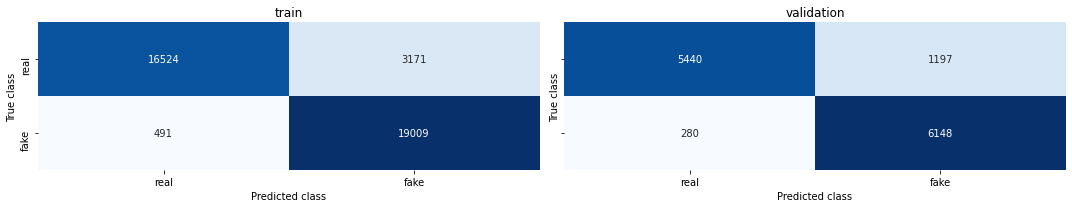

In [64]:
model_tree = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = 10, random_state=42)),
])

model_tree.fit(train, train.user_class)

evaluate_model(model_tree, title='Decision Tree')

### **RANDOM FOREST**

### **GRADIENT BOOSTED TREES**

4) Se deben utilizar **técnicas** que garanticen que los modelos no están **sobreentrenando** sin que nos demos cuenta.

5) Determinar el valor final de la **métrica** que podría ser informado al cliente, utilizando técnicas que permitan obtener un valor lo más realista posible. Fundamentar.